In [72]:
import pandas as pd
from google.colab import drive
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [74]:
financial_data_path = '/content/drive/MyDrive/Colab Notebooks/test_analytics/financial_data.csv'
prolongations_data_path = '/content/drive/MyDrive/Colab Notebooks/test_analytics/prolongations.csv'

financial_dataframe = pd.read_csv(financial_data_path)
prolongations_dataframe = pd.read_csv(prolongations_data_path)

In [75]:
financial_dataframe

,id,Причина дубля,Ноябрь 2022,Декабрь 2022,Январь 2023,Февраль 2023,Март 2023,Апрель 2023,Май 2023,Июнь 2023,Июль 2023,Август 2023,Сентябрь 2023,Октябрь 2023,Ноябрь 2023,Декабрь 2023,Январь 2024,Февраль 2024,Account
0,42,NaN,"36 220,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
1,657,первая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
2,657,вторая часть оплаты,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
3,594,NaN,стоп,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
4,665,NaN,"10 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Васильев Артем Александрович
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,281,основные работы,"76 550,00","79 950,00","66 900,00","89 150,00","108 450,00","77 100,00","78 800,00","126 740,00","117 730,00","115 860,00","160 770,00","142 490,00","99 125,00","74 350,00","105 775,00","92 065,00",Соколова Анастасия Викторовна
447,281,доп работы,"21 450,00","13 300,00","15 900,00","19 850,00","17 350,00","14 650,00","15 900,00","3 000,00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Соколова Анастасия Викторовна
448,785,NaN,NaN,NaN,NaN,"5 306,60","12 898,10","5 287,00","10 180,00","8 600,00","3 860,00","8 600,00","700,00","700,00",в ноль,в ноль,NaN,NaN,Соколова Анастасия Викторовна
449,913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"58 200,00","58 200,00","58 200,00","58 200,00","58 200,00","58 200,00",NaN,NaN,Смирнова Ольга Владимировна


In [76]:
prolongations_dataframe

,id,month,AM
0,42,ноябрь 2022,Васильев Артем Александрович
1,453,ноябрь 2022,Васильев Артем Александрович
2,548,ноябрь 2022,Михайлов Андрей Сергеевич
3,87,ноябрь 2022,Соколова Анастасия Викторовна
4,429,ноябрь 2022,Соколова Анастасия Викторовна
...,...,...,...
472,955,декабрь 2023,Смирнова Ольга Владимировна
473,1004,декабрь 2023,без А/М
474,281,декабрь 2023,Соколова Анастасия Викторовна
475,785,декабрь 2023,Соколова Анастасия Викторовна


In [78]:
def clean_financial_data(df):

    # создаем копию датафрейма
    df_clean = df.copy()


    # получаем список всех колонок с месяцами (исключая служебные колонки)
    monthes = [col for col in df_clean.columns if col not in ['id', 'Причина дубля', 'Account']]


    # создаем словарь для преобразования русских названий месяцев в числовые значения
    rus_months = {
        'январь': 1, 'февраль': 2, 'март': 3, 'апрель': 4, 'май': 5,
        'июнь': 6, 'июль': 7, 'август': 8, 'сентябрь': 9, 'октябрь': 10,
        'ноябрь': 11, 'декабрь': 12
    }


    # создаем функцию для преобразования строки с названием месяца в объект datetime
    # это позволит нам правильно отсортировать месяцы в хронологическом порядке
    def convert_month_to_date(month_str):
        s = str(month_str).lower()
        year_match = re.search(r'\d{4}', s)
        year = int(year_match.group(0)) if year_match else 9999
        month = next((rus_months[m] for m in rus_months if m in s), 12)
        return datetime(year, month, 1)


    # проводим сортировку месяцев в хронологическом порядке
    monthes_sorted = sorted(monthes, key=convert_month_to_date)
    print(f"найдено {len(monthes_sorted)} месяцев для обработки")


    # исключаем проекты, которые завершились
    exclude_projects = set()
    for idx, row in df_clean.iterrows():
        project_id = row['id']
        # находим последний месяц, в котором есть данные по проекту
        last_month_with_data = next((m for m in reversed(monthes_sorted) if pd.notna(row[m])), None)
        if last_month_with_data:
            last_value = str(row[last_month_with_data]).strip().lower()
            # проводим проверку, помечен ли проект как завершенный
            if last_value in ['стоп', 'stop', 'end']:
                exclude_projects.add(project_id)
    print(f"stop/end кол-во: {len(exclude_projects)}")
    # удаляем завершенные проекты
    df_clean = df_clean[~df_clean['id'].isin(exclude_projects)]


    # обрабатываем "в ноль" и заменяем его на значение из предыдущего месяца
    for i, month in enumerate(monthes_sorted):
        if i == 0: # пропускаем первый месяц
            continue
        prev_month = monthes_sorted[i - 1]
        for idx in df_clean.index:
            val = str(df_clean.at[idx, month]).strip().lower() if pd.notna(df_clean.at[idx, month]) else ""
            if val == 'в ноль':
                prev_val = df_clean.at[idx, prev_month]
                prev_str = str(prev_val).strip().lower() if pd.notna(prev_val) else ""
                # проверяем, что предыдущее значение число, а не другое специальное значение
                if prev_str not in ['в ноль', 'стоп', 'end', '']:
                    try:
                        # меняем предыдущее значение в float и копируем в текущий месяц
                        df_clean.at[idx, month] = float(
                            str(prev_val)
                            .replace('\xa0','') # убираем неразрывные пробелы
                            .replace('\u2009','') # убираем тонкие пробелы
                            .replace(' ', '') # убираем обычные пробелы
                            .replace(',', '.') # заменяем запятую на точку для float
                        )
                    except (ValueError, TypeError):
                        # пропускаем, если не удалось поменять
                        pass


    # меняем все числовые ячеек на float
    for month in monthes_sorted:
        for idx in df_clean.index:
            val = df_clean.at[idx, month]
            if pd.notna(val):
                s = str(val).strip().lower()
                # пропускаем специальные значения, преобразуем только числовые
                if s not in ['стоп', 'end', 'в ноль']:
                    try:
                        df_clean.at[idx, month] = float(
                            s.replace('\xa0','')
                             .replace('\u2009','')
                             .replace(' ', '')
                             .replace(',', '.')
                        )
                    except (ValueError, TypeError):
                        # пропускаем, если не удалось преобразовать в число
                        pass


    print(f"после очистки осталось {len(df_clean)} строк")

    # выводим очищенный датафрейм и отсортированный список месяцев
    return df_clean, monthes_sorted

In [66]:
clean_financial_data(financial_dataframe)

Найдено 16 месяцев для обработки
stop/end кол-во: 53
После очистки осталось 377 строк


(      id        Причина дубля Ноябрь 2022 Декабрь 2022 Январь 2023  \
 0     42                  NaN     36220.0          NaN         NaN   
 4    665                  NaN     10000.0          NaN         NaN   
 5    637                  NaN     38045.0          NaN         NaN   
 6    419                  NaN         NaN          NaN         NaN   
 7    578                  NaN     82800.0          NaN         NaN   
 ..   ...                  ...         ...          ...         ...   
 446  281      основные работы     76550.0      79950.0     66900.0   
 447  281           доп работы     21450.0      13300.0     15900.0   
 448  785                  NaN         NaN          NaN         NaN   
 449  913                  NaN         NaN          NaN         NaN   
 450  930  первая часть оплаты         NaN          NaN         NaN   
 
     Февраль 2023 Март 2023 Апрель 2023 Май 2023 Июнь 2023 Июль 2023  \
 0            NaN       NaN         NaN      NaN       NaN       NaN   
 4

In [79]:
financial_data_clean, monthes_sorted_result = clean_financial_data(financial_dataframe)

merged_data = prolongations_dataframe.merge(financial_data_clean, on='id', how='left', suffixes=('_prolong', '_financial'))

print('\n', merged_data['AM'].value_counts())

print(merged_data)

найдено 16 месяцев для обработки
stop/end кол-во: 53
после очистки осталось 377 строк

 AM
Васильев Артем Александрович     190
Соколова Анастасия Викторовна    142
Попова Екатерина Николаевна      120
Смирнова Ольга Владимировна       96
Иванова Мария Сергеевна           63
Михайлов Андрей Сергеевич         36
Кузнецов Михаил Иванович          36
без А/М                            2
Федорова Марина Васильевна         2
Петрова Анна Дмитриевна            1
Name: count, dtype: int64
       id         month                             AM    Причина дубля  \
0      42   ноябрь 2022   Васильев Артем Александрович              NaN   
1     453   ноябрь 2022   Васильев Артем Александрович              NaN   
2     548   ноябрь 2022      Михайлов Андрей Сергеевич              NaN   
3      87   ноябрь 2022  Соколова Анастасия Викторовна  основные работы   
4     429   ноябрь 2022  Соколова Анастасия Викторовна              NaN   
..    ...           ...                            ...         

In [80]:
def calculate_prolongation_coefficients(merged_data, month_columns_sorted):

    # ищем месяцы, содержащие "2023" в названии ячеек
    months_2023 = [m for m in month_columns_sorted if re.search(r'2023', str(m))]
    print(f"месяцы 2023 для анализа {months_2023}")
    results = []


    # цикл по месяцам 2023 года, начиная с марта
    for i, current_month in enumerate(months_2023):
        if i < 2:
            continue


        # определение временных периодов для анализа
        previous_month = months_2023[i - 1]
        two_months_ago = months_2023[i - 2]

        print(f"\nрасчет для {current_month}")
        print(f"текущий месяц {current_month}")
        print(f"проекты завершились в {previous_month}")
        print(f"проекты завершились 2 месяца назад {two_months_ago}")


        # получение уникального списка менеджеров для анализа
        managers = [m for m in merged_data['AM'].dropna().unique()]


        for manager in managers:
            # фильтрация данных по текущему менеджеру
            manager_data = merged_data[merged_data['AM'] == manager]


            # инициализация датафреймов для хранения промежуточных результатов
            projects_ended_prev_month = pd.DataFrame()
            projects_prolonged_first = pd.DataFrame()
            projects_ended_two_months_ago = pd.DataFrame()
            projects_not_prolonged_prev = pd.DataFrame()
            projects_prolonged_second = pd.DataFrame()



            # РАСЧЕТ КОЭФФИЦИЕНТА K1

            # преобразование значений предыдущего месяца в числовой формат
            prev_vals = pd.to_numeric(manager_data[previous_month], errors='coerce')


            # выбираем проекты, которые завершились в предыдущем месяце
            projects_ended_prev_month = manager_data[prev_vals > 0]


            if not projects_ended_prev_month.empty:
                # общая сумма проектов, завершившихся в предыдущем месяце
                total_ended_prev = prev_vals[prev_vals > 0].sum()
                # преобразование значений текущего месяца в числовой формат
                curr_vals = pd.to_numeric(projects_ended_prev_month[current_month], errors='coerce')
                # проекты, которые были пролонгированы в текущем месяце
                projects_prolonged_first = projects_ended_prev_month[curr_vals > 0]
                # общая сумма пролонгированных проектов
                total_prolonged_first = curr_vals[curr_vals > 0].sum()


                k1 = total_prolonged_first / total_ended_prev if total_ended_prev > 0 else 0
                print(f"  {manager}: K1 -- {len(projects_ended_prev_month)} заверш., {len(projects_prolonged_first)} пролонг., сумма {total_ended_prev:.0f} → {total_prolonged_first:.0f}")
            else:
                k1 = 0
                print(f"  {manager}: K1 -- нет завершившихся проектов")



            # РАСЧЕТ КОЭФФИЦИЕНТА K2

            # преобразование значений двухмесячной давности в числовой формат
            two_ago_vals = pd.to_numeric(manager_data[two_months_ago], errors='coerce')


            # проекты, которые завершились два месяца назад
            projects_ended_two_months_ago = manager_data[two_ago_vals > 0]

            if not projects_ended_two_months_ago.empty:
                # проверка пролонгации в предыдущем месяце
                prev_vals = pd.to_numeric(projects_ended_two_months_ago[previous_month], errors='coerce')
                # проекты, которые НЕ были пролонгированы в предыдущем месяце
                projects_not_prolonged_prev = projects_ended_two_months_ago[(prev_vals.isna()) | (prev_vals == 0)]


                if not projects_not_prolonged_prev.empty:
                    # общая сумма проектов, завершившихся два месяца назад и не пролонгированных в предыдущем месяце
                    total_ended_two_months = pd.to_numeric(projects_not_prolonged_prev[two_months_ago], errors='coerce').sum()
                    # проверка пролонгации в текущем месяце
                    curr_vals = pd.to_numeric(projects_not_prolonged_prev[current_month], errors='coerce')
                    # проекты, которые были пролонгированы в текущем месяце
                    projects_prolonged_second = projects_not_prolonged_prev[curr_vals > 0]
                    # общая сумма вернувшихся проектов
                    total_prolonged_second = curr_vals[curr_vals > 0].sum()


                    k2 = total_prolonged_second / total_ended_two_months if total_ended_two_months > 0 else 0
                    print(f"  {manager}: K2 -- {len(projects_not_prolonged_prev)} не пролонг., {len(projects_prolonged_second)} вернулось, сумма {total_ended_two_months:.0f} → {total_prolonged_second:.0f}")
                else:
                    k2 = 0
                    print(f"  {manager}: K2 -- все проекты пролонгированы в первый месяц")
            else:
                k2 = 0
                print(f"  {manager}: K2 -- нет завершившихся проектов 2 месяца назад")


            results.append({
                'Manager': manager,
                'Month': current_month,
                'K1': round(k1, 4),
                'K2': round(k2, 4),
                'K1_percent': round(k1 * 100, 2),
                'K2_percent': round(k2 * 100, 2),
                'Projects_ended_prev': len(projects_ended_prev_month),
                'Projects_prolonged_first': len(projects_prolonged_first),
                'Projects_ended_two_months': len(projects_not_prolonged_prev),
                'Projects_prolonged_second': len(projects_prolonged_second)
            })

    return pd.DataFrame(results)

# вызов функции расчета коэффициентов пролонгации
results_df = calculate_prolongation_coefficients(merged_data, monthes_sorted_result)


print("\nрезультаты расчета коэффициентов")
results_df

месяцы 2023 для анализа ['Январь 2023', 'Февраль 2023', 'Март 2023', 'Апрель 2023', 'Май 2023', 'Июнь 2023', 'Июль 2023', 'Август 2023', 'Сентябрь 2023', 'Октябрь 2023', 'Ноябрь 2023', 'Декабрь 2023']

расчет для Март 2023
текущий месяц Март 2023
проекты завершились в Февраль 2023
проекты завершились 2 месяца назад Январь 2023
  Васильев Артем Александрович: K1 -- 86 заверш., 75 пролонг., сумма 10237326 → 8886982
  Васильев Артем Александрович: K2 -- 6 не пролонг., 3 вернулось, сумма 259478 → 203322
  Михайлов Андрей Сергеевич: K1 -- 20 заверш., 16 пролонг., сумма 3424926 → 2400924
  Михайлов Андрей Сергеевич: K2 -- все проекты пролонгированы в первый месяц
  Соколова Анастасия Викторовна: K1 -- 59 заверш., 57 пролонг., сумма 3653570 → 3634615
  Соколова Анастасия Викторовна: K2 -- 19 не пролонг., 2 вернулось, сумма 790008 → 45775
  Иванова Мария Сергеевна: K1 -- 18 заверш., 17 пролонг., сумма 2339336 → 2228314
  Иванова Мария Сергеевна: K2 -- 1 не пролонг., 0 вернулось, сумма 243592 →

,Manager,Month,K1,K2,K1_percent,K2_percent,Projects_ended_prev,Projects_prolonged_first,Projects_ended_two_months,Projects_prolonged_second
0,Васильев Артем Александрович,Март 2023,0.8681,0.7836,86.81,78.36,86,75,6,3
1,Михайлов Андрей Сергеевич,Март 2023,0.7010,0.0000,70.10,0.00,20,16,0,0
2,Соколова Анастасия Викторовна,Март 2023,0.9948,0.0579,99.48,5.79,59,57,19,2
3,Иванова Мария Сергеевна,Март 2023,0.9525,0.0000,95.25,0.00,18,17,1,0
4,Попова Екатерина Николаевна,Март 2023,0.9266,0.0000,92.66,0.00,39,34,6,0
...,...,...,...,...,...,...,...,...,...,...
95,Смирнова Ольга Владимировна,Декабрь 2023,0.8160,0.4812,81.60,48.12,49,35,12,5
96,Кузнецов Михаил Иванович,Декабрь 2023,0.7920,0.0000,79.20,0.00,24,21,0,0
97,без А/М,Декабрь 2023,0.0000,0.0000,0.00,0.00,1,0,0,0
98,Петрова Анна Дмитриевна,Декабрь 2023,1.1112,0.0000,111.12,0.00,1,1,0,0


In [83]:
# годовые итоги по менеджерам
yearly_summary = results_df.groupby('Manager').agg({
    'K1': 'mean',
    'K2': 'mean',
    'Projects_ended_prev': 'sum',
    'Projects_prolonged_first': 'sum',
    'Projects_prolonged_second': 'sum'
}).round(4)

# добавляем проценты
yearly_summary['K1_percent'] = (yearly_summary['K1'] * 100).round(1)
yearly_summary['K2_percent'] = (yearly_summary['K2'] * 100).round(1)

print("ГОДОВЫЕ ИТОГИ:")
yearly_summary

ГОДОВЫЕ ИТОГИ:


,K1,K2,Projects_ended_prev,Projects_prolonged_first,Projects_prolonged_second,K1_percent,K2_percent
Manager,,,,,,,
Васильев Артем Александрович,0.8853,0.1504,808,696,16,88.5,15.0
Иванова Мария Сергеевна,0.8808,0.1000,155,134,1,88.1,10.0
Кузнецов Михаил Иванович,0.9408,0.0505,206,197,1,94.1,5.1
Михайлов Андрей Сергеевич,0.8822,0.0000,163,146,0,88.2,0.0
Петрова Анна Дмитриевна,0.1111,0.0000,1,1,0,11.1,0.0
Попова Екатерина Николаевна,0.9285,0.1961,531,487,7,92.8,19.6
Смирнова Ольга Владимировна,0.9137,0.3964,405,348,18,91.4,39.6
Соколова Анастасия Викторовна,0.9254,0.0704,617,558,7,92.5,7.0
Федорова Марина Васильевна,0.6380,0.0000,10,9,0,63.8,0.0


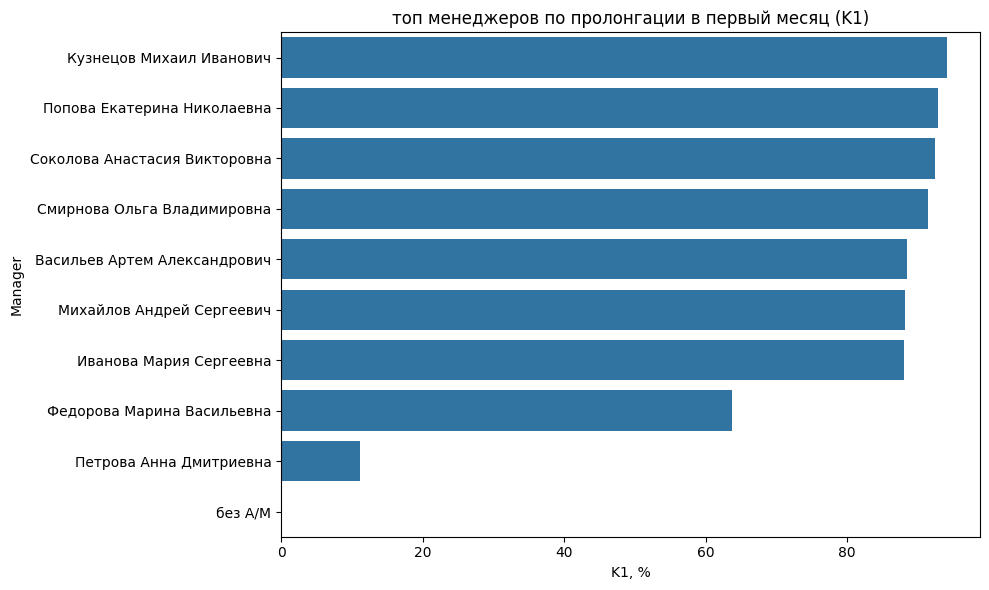

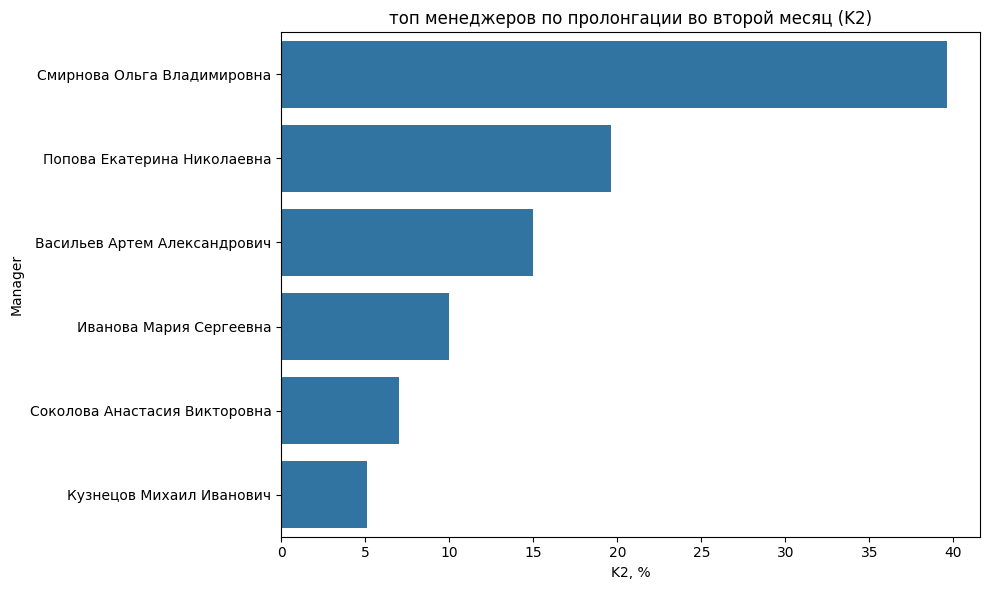

<Figure size 1200x600 with 0 Axes>

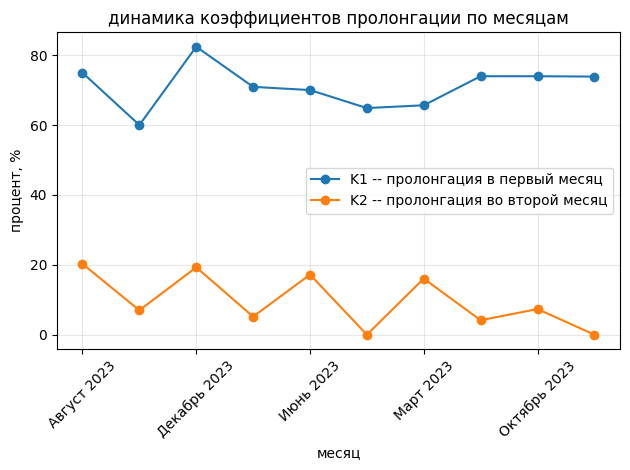

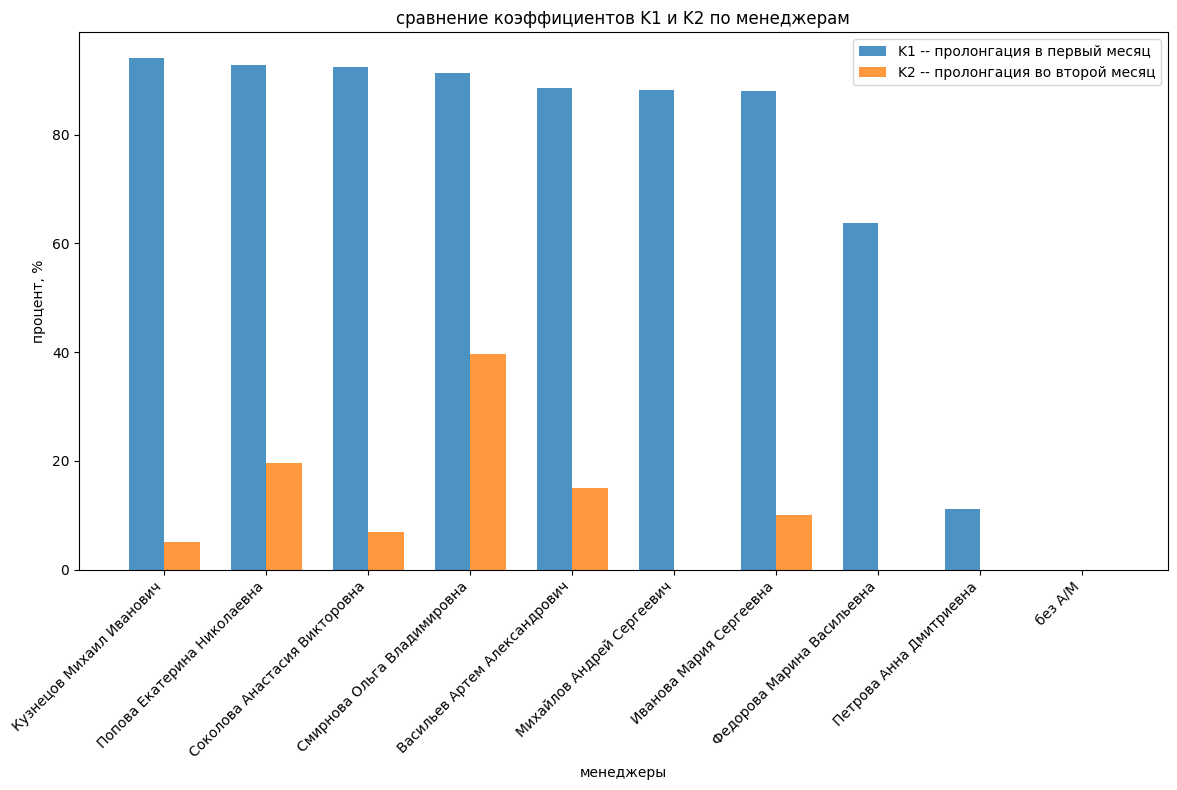

In [82]:
# график топ менеджеров по K1
plt.figure(figsize=(10, 6))
top_managers = yearly_summary.nlargest(10, 'K1_percent')
sns.barplot(data=top_managers.reset_index(), x='K1_percent', y='Manager')
plt.title('топ менеджеров по пролонгации в первый месяц (K1)')
plt.xlabel('K1, %')
plt.tight_layout()
plt.show()


# график топ менеджеров по K2
plt.figure(figsize=(10, 6))
top_managers_k2 = yearly_summary[yearly_summary['K2_percent'] > 0].nlargest(10, 'K2_percent')
if len(top_managers_k2) > 0:
    sns.barplot(data=top_managers_k2.reset_index(), x='K2_percent', y='Manager')
    plt.title('топ менеджеров по пролонгации во второй месяц (K2)')
    plt.xlabel('K2, %')
    plt.tight_layout()
    plt.show()
else:
    print("нет данных для построения графика K2")


# график динамика по месяцам
plt.figure(figsize=(12, 6))
pivot_data = results_df.pivot_table(
    index='Month',
    values=['K1_percent', 'K2_percent'],
    aggfunc='mean'
)
pivot_data.plot(kind='line', marker='o')
plt.title('динамика коэффициентов пролонгации по месяцам')
plt.ylabel('процент, %')
plt.xlabel('месяц')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(['K1 -- пролонгация в первый месяц', 'K2 -- пролонгация во второй месяц'])
plt.tight_layout()
plt.show()


# график соотношения K1 и K2 по менеджерам
plt.figure(figsize=(12, 8))
active_managers = yearly_summary[yearly_summary['Projects_ended_prev'] > 0]


if len(active_managers) > 0:
    # Сортируем по K1 для красивого отображения
    active_managers = active_managers.sort_values('K1_percent', ascending=False)

    x = range(len(active_managers))
    width = 0.35

    plt.bar(x, active_managers['K1_percent'], width, label='K1 -- пролонгация в первый месяц', alpha=0.8)
    plt.bar([i + width for i in x], active_managers['K2_percent'], width, label='K2 -- пролонгация во второй месяц', alpha=0.8)

    plt.xlabel('менеджеры')
    plt.ylabel('процент, %')
    plt.title('сравнение коэффициентов K1 и K2 по менеджерам')
    plt.xticks([i + width/2 for i in x], active_managers.index, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()